In [61]:
# Part 0. 동영상에서 1초당 정지 사진 추출 저장
import cv2
import math
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

count = 0
videoFile = "/content/drive/MyDrive/AI/week10/week10_data/Tom and Jerry.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) # frame rate

x = 1
while(cap.isOpened()):
  frameId = cap.get(1) # current frame number
  ret, frame = cap.read()

  if (ret != True):
    break

  if (frameId % math.floor(frameRate) == 0):
    filename = "frame%d.jpg" % count;count+=1
    cv2.imwrite(filename, frame)

cap.release()
print("Done!")

Mounted at /content/drive
Done!


In [63]:
count = 0
videoFile = "/content/drive/MyDrive/AI/week10/week10_data/Tom and Jerry 3.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) # frame rate

x = 1
while(cap.isOpened()):
  frameId = cap.get(1) # current frame number
  ret, frame = cap.read()

  if (ret != True):
    break

  if (frameId % math.floor(frameRate) == 0):
    filename = "test%d.jpg" % count;count+=1
    cv2.imwrite(filename, frame)

cap.release()
print("Done!")

Done!


In [64]:
# Part 1. 사진 데이터 입력 및 크기 변경
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from skimage.transform import resize

data = pd.read_csv("/content/drive/MyDrive/AI/week10/week10_data/mapping.csv")
test = pd.read_csv("/content/drive/MyDrive/AI/week10/week10_data/testing.csv")

X = []
for img_name in data.Image_ID:
  img = plt.imread("/content/" + img_name)
  X.append(img)
X = np.array(X)

test_image = []
for img_name in test.Image_ID:
  img = plt.imread("/content/" + img_name)
  test_image.append(img)
test_img = np.array(test_image)

from keras.utils import to_categorical
train_y = to_categorical(data.Class)
test_y = to_categorical(test.Class)

image = []
for i in range(0, X.shape[0]):
  a = resize(X[i], preserve_range=True, output_shape=(224, 224, 3)).astype(int)
  image.append(a)
X = np.array(image)

test_image = []
for i in range(0, test_img.shape[0]):
  a = resize(test_img[i], preserve_range=True, output_shape=(224, 224, 3)).astype(int)
  test_image.append(a)
test_image = np.array(test_image)

In [65]:
# Part 2 : VGG16 기반 입력 사진 특성 추출
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, train_y, test_size=0.3, random_state=42)

from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [66]:
# Part 3 : VGG16 기반 자체 모델 생성
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='sigmoid')) # hidden layer
model.add(Dense(512, activation='sigmoid')) # hidden layer
model.add(Dense(256, activation='sigmoid')) # hidden layer
model.add(Dense(3, activation='softmax')) # output layer

from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath = 'weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stopping_callback, checkpoint])

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.9642 - accuracy: 0.5385
Epoch 1: val_loss improved from inf to 0.81002, saving model to weights.best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 29s 4s/step - loss: 0.9642 - accuracy: 0.5385 - val_loss: 0.8100 - val_accuracy: 0.6111
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.5806 - accuracy: 0.8077
Epoch 2: val_loss improved from 0.81002 to 0.57181, saving model to weights.best.hdf5
7/7 [==============================] - 33s 5s/step - loss: 0.5806 - accuracy: 0.8077 - val_loss: 0.5718 - val_accuracy: 0.7444
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.8990
Epoch 3: val_loss improved from 0.57181 to 0.37553, saving model to weights.best.hdf5
7/7 [==============================] - 27s 4s/step - loss: 0.3204 - accuracy: 0.8990 - val_loss: 0.3755 - val_accuracy: 0.9000
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.9375
Epoch 4: val_loss improved from 0.37553 to 0.33467, saving model to weights.best.hdf5
7/7 [==============================] - 24s 4s/step - loss: 0.2032 - accuracy: 0.93

6/6 [==============================] - 1s 125ms/step - loss: 1.4812 - accuracy: 0.6237
Real Test accuracy: 62.37%
6/6 [==============================] - 1s 122ms/step
The screen time of None is  25 seconds
The screen time of Jerry is  10 seconds
The screen time of Tom is  151 seconds


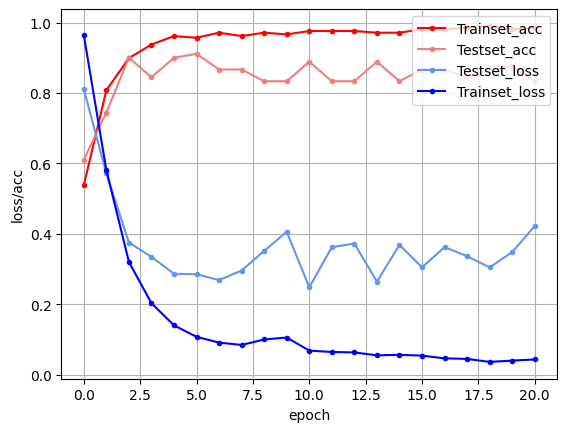

In [67]:
# Part 4 : 생성 모델 성능 평가
scores = model.evaluate(test_image, test_y)
print("Real Test %s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

predictions = np.argmax(model.predict(test_image), axis=-1)
print("The screen time of None is ", predictions[predictions==0].shape[0], "seconds")
print("The screen time of Jerry is ", predictions[predictions==1].shape[0], "seconds")
print("The screen time of Tom is ", predictions[predictions==2].shape[0], "seconds")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, acc, marker=".", c="red", label="Trainset_acc")
plt.plot(x_len, val_acc, marker=".", c="lightcoral", label="Testset_acc")
plt.plot(x_len, y_vloss, marker=".", c="cornflowerblue", label="Testset_loss")
plt.plot(x_len, y_loss, marker=".", c="blue", label="Trainset_loss")

plt.legend(loc="upper right")
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss/acc")
plt.show()